In [25]:
from collections import Counter, namedtuple
from dataclasses import dataclass
import csv
import json

import numpy as np, scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd

## Fine-Grained Error Analysis on Purple Categories

In [24]:
raw_data = json.load(open("../data/puzzle_data.json", "r"))

@dataclass
class Color():
    YELLOW = '#fbd400'
    GREEN = '#69e352'
    BLUE = '#5492ff'
    PURPLE = '#df7bea'
    OVERALL = '#A9A9A9'

In [16]:
# Save the unlabelled categories
purple_categories = []
for game in raw_data:
    final_category = [category for category in game['answers'] if category['color'] == Color.PURPLE][0]
    purple_categories.append([final_category['description'], final_category['words']])

with open('../data/purple_categories.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Category', 'Words'])
    for category in purple_categories:
        writer.writerow(category)

In [17]:
# Load the labelled categories
category_labels = []
with open('../data/purple_categories_labelled.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        category_labels.append(row[2])

In [18]:
print("===== Category Label Breakdown =====")
counts = Counter(category_labels)
for label, count in sorted(counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{label}: {count} ({count/len(category_labels)*100:.2f}%)")

===== Category Label Breakdown =====
Phrasal: 52 (34.90%)
Abstract: 33 (22.15%)
Cultural: 30 (20.13%)
Morphological: 15 (10.07%)
Semantic: 14 (9.40%)
Miscellaneous: 5 (3.36%)


In [19]:
model_types = [
    "gpt-3.5-turbo_cot-False",
    "gpt-4-1106-preview_cot-False",
    "gpt-4-1106-preview_cot-True",
]

success_rate_results = {}
num_failures_results = {}

for model in model_types:
    filename = f"../results/IterativeGPTSolver_{model}_results.json"
    df = pd.read_json(filename)
    
    
    results_by_category_label = {}
    num_failures_by_category_label = {}

    for label, (id, group) in zip(category_labels, df.groupby("puzzle_id")):
        if label not in results_by_category_label:
            results_by_category_label[label] = []
            num_failures_by_category_label[label] = 0

        results_by_category_label[label] += group["solved_purple"].tolist()

        num_failures = group["solved_purple"].tolist().count(False)
        num_failures_by_category_label[label] += num_failures
        
        # is_failure = group["solved_purple"].tolist().count(True) == 0
        # if is_failure:
        #     num_failures_by_category_label[label] += 1


    success_rate_results[model] = results_by_category_label
    num_failures_results[model] = num_failures_by_category_label

In [20]:
for model_type, num_failures_by_category_label in num_failures_results.items():
    print(f"\n==================== {model_type} Results ====================")
    total_failures = sum(list(num_failures_by_category_label.values()))
    for label, failures in sorted(num_failures_by_category_label.items(), key=lambda x: x[1], reverse=True):
        print(f"{label}: {failures} ({failures/total_failures*100:.2f}%)")


==================== gpt-3.5-turbo_cot-False Results ====================
Phrasal: 138 (34.41%)
Abstract: 92 (22.94%)
Cultural: 77 (19.20%)
Morphological: 40 (9.98%)
Semantic: 40 (9.98%)
Miscellaneous: 14 (3.49%)

==================== gpt-4-1106-preview_cot-False Results ====================
Phrasal: 107 (38.08%)
Abstract: 61 (21.71%)
Cultural: 56 (19.93%)
Morphological: 26 (9.25%)
Semantic: 20 (7.12%)
Miscellaneous: 11 (3.91%)

==================== gpt-4-1106-preview_cot-True Results ====================
Phrasal: 85 (37.28%)
Abstract: 51 (22.37%)
Cultural: 42 (18.42%)
Morphological: 24 (10.53%)
Semantic: 15 (6.58%)
Miscellaneous: 11 (4.82%)


In [21]:
confidence = 0.95
for model_type, results_by_category_label in success_rate_results.items():
    print(f"\n==================== {model_type} Results ====================")
    for label, solves in sorted(results_by_category_label.items(), key=lambda x: np.mean(x[1]), reverse=True):
        prop = np.mean(solves)
        interval = st.t.interval(confidence, len(solves)-1, loc=np.mean(solves), scale=st.sem(solves))
        interval_plus_minus = (interval[1] - interval[0]) / 2

        # print(f"{label}: \t\t{prop*100:.2f}% ± {interval_plus_minus*100:.2f}%   \t\t({confidence*100}% confidence, {len(solves) // 3} puzzles)")
        print(f"{label}: \t\t{prop*100:.2f}%   \t\t({len(solves) // 3} puzzles)")


==================== gpt-3.5-turbo_cot-False Results ====================
Cultural: 		14.44%   		(30 puzzles)
Phrasal: 		11.54%   		(52 puzzles)
Morphological: 		11.11%   		(15 puzzles)
Abstract: 		7.07%   		(33 puzzles)
Miscellaneous: 		6.67%   		(5 puzzles)
Semantic: 		4.76%   		(14 puzzles)

==================== gpt-4-1106-preview_cot-False Results ====================
Semantic: 		52.38%   		(14 puzzles)
Morphological: 		42.22%   		(15 puzzles)
Abstract: 		38.38%   		(33 puzzles)
Cultural: 		37.78%   		(30 puzzles)
Phrasal: 		31.41%   		(52 puzzles)
Miscellaneous: 		26.67%   		(5 puzzles)

==================== gpt-4-1106-preview_cot-True Results ====================
Semantic: 		64.29%   		(14 puzzles)
Cultural: 		53.33%   		(30 puzzles)
Abstract: 		48.48%   		(33 puzzles)
Morphological: 		46.67%   		(15 puzzles)
Phrasal: 		45.51%   		(52 puzzles)
Miscellaneous: 		26.67%   		(5 puzzles)


## Analysis with Fewer Mistakes Allowed

In [22]:
model_types = [
    "gpt-3.5-turbo_cot-False",
    "gpt-4-1106-preview_cot-False",
    "gpt-4-1106-preview_cot-True",
]

for model in model_types:
    filename = f"../results/IterativeGPTSolver_{model}_results.json"
    df = pd.read_json(filename)

    solved = df[df["solved_overall"] == True].copy()
    solved["mistakes"] = (solved["num_steps"] - solved["num_invalid"]) - 3 # 3 is the number of successes required since the last action is automatic

    print(f"\n==================== {model_type} Results ====================")
    for n in range(5):
        solved_witin_n_mistakes = len(solved[solved["mistakes"] <= n])
        prop = solved_witin_n_mistakes / 450

        print(f"Solved with {n} or fewer mistakes: \t\t{prop*100:.2f}%   \t\t({solved_witin_n_mistakes // 3} puzzles)")



==================== gpt-4-1106-preview_cot-True Results ====================
Solved with 0 or fewer mistakes: 		2.67%   		(4 puzzles)
Solved with 1 or fewer mistakes: 		4.22%   		(6 puzzles)
Solved with 2 or fewer mistakes: 		4.67%   		(7 puzzles)
Solved with 3 or fewer mistakes: 		5.56%   		(8 puzzles)
Solved with 4 or fewer mistakes: 		6.89%   		(10 puzzles)

==================== gpt-4-1106-preview_cot-True Results ====================
Solved with 0 or fewer mistakes: 		19.11%   		(28 puzzles)
Solved with 1 or fewer mistakes: 		25.33%   		(38 puzzles)
Solved with 2 or fewer mistakes: 		29.78%   		(44 puzzles)
Solved with 3 or fewer mistakes: 		32.67%   		(49 puzzles)
Solved with 4 or fewer mistakes: 		35.11%   		(52 puzzles)

==================== gpt-4-1106-preview_cot-True Results ====================
Solved with 0 or fewer mistakes: 		19.11%   		(28 puzzles)
Solved with 1 or fewer mistakes: 		30.89%   		(46 puzzles)
Solved with 2 or fewer mistakes: 		35.78%   		(53 puzzles)
Solve

## Analysis when Invalid Guesses are Counted as Mistakes

In [23]:
model_types = [
    "gpt-3.5-turbo_cot-False",
    "gpt-4-1106-preview_cot-False",
    "gpt-4-1106-preview_cot-True",
]

for model in model_types:
    filename = f"../results/IterativeGPTSolver_{model}_results.json"
    df = pd.read_json(filename)

    solved = df[df["solved_overall"] == True].copy()
    solved["mistakes"] = solved["num_steps"] - 3 # 3 is the number of successes required since the last action is automatic

    solved_witin_5_mistakes = len(solved[solved["mistakes"] <= 4])
    prop = solved_witin_5_mistakes / 450

    print(f"{model}: \t\t{prop*100:.2f}%   \t\t({solved_witin_5_mistakes // 3} puzzles)")

gpt-3.5-turbo_cot-False: 		6.67%   		(10 puzzles)
gpt-4-1106-preview_cot-False: 		35.11%   		(52 puzzles)
gpt-4-1106-preview_cot-True: 		45.33%   		(68 puzzles)


## Analyses of Difficulty

In [26]:
difficulties = [game['difficulty'] for game in raw_data if game['difficulty'] is not None]

(array([ 2.,  3., 13., 20., 30., 18., 18., 13.,  4.,  3.]),
 array([1.3 , 1.65, 2.  , 2.35, 2.7 , 3.05, 3.4 , 3.75, 4.1 , 4.45, 4.8 ]),
 <BarContainer object of 10 artists>)

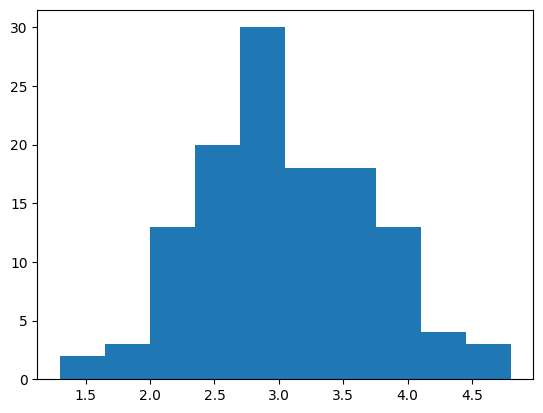

In [32]:
plt.hist(difficulties, bins=10)